# 시계열 분석 
## fbprophet 
### 데이터가 적어도 잘 작동하는편
### 월간, 주간, 일간, 휴일별 분석가능

참고 url : https://zzsza.github.io/data/2019/02/06/prophet/


In [2]:
from fbprophet import Prophet
import pandas as pd
import numpy as np

df = pd.read_excel('./data/NSshop/2019_data_time.xlsx',header=1)

Importing plotly failed. Interactive plots will not work.


#### 결측값(상품군:무형)제거, 방송일시 20200101 -> 20191231로 변경할 필요가없음! -> 시간대로표시되기 때문

In [3]:
df.dropna(inplace=True)
#df.loc[df['방송일시'] == '2020-01-01 00:00:00', '방송일시'] = '2019-12-31 23:50:00'

#### prophet은 기본적으로 ds column과 y column이 필요하다

In [4]:
df['ds'] = df['방송일시']
df['y'] = df['취급액']

df_v = df.pivot_table(index="ds", values="y", aggfunc=np.sum)
df_v['ds']= df_v.index

In [123]:
#model = Prophet() 
model = Prophet(seasonality_mode='multiplicative')
model.fit(df_v)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [124]:
future = model.make_future_dataframe(periods=365)

In [125]:
future

,ds
0,2019-01-01 06:00:00
1,2019-01-01 06:20:00
2,2019-01-01 06:40:00
3,2019-01-01 07:00:00
4,2019-01-01 07:20:00
...,...
20948,2020-12-27 00:00:00
20949,2020-12-28 00:00:00
20950,2020-12-29 00:00:00
20951,2020-12-30 00:00:00


In [126]:
forecast = model.predict(future)

In [127]:
forecast[['ds','yhat']]

,ds,yhat
0,2019-01-01 06:00:00,1.312654e+07
1,2019-01-01 06:20:00,1.540082e+07
2,2019-01-01 06:40:00,1.775449e+07
3,2019-01-01 07:00:00,2.020971e+07
4,2019-01-01 07:20:00,2.277300e+07
...,...,...
20948,2020-12-27 00:00:00,1.133632e+08
20949,2020-12-28 00:00:00,9.463738e+07
20950,2020-12-29 00:00:00,8.299967e+07
20951,2020-12-30 00:00:00,8.738941e+07


#### y=2일때를 기준으로 보면 10월이후 취급액이 급증함 -> seasonality인지 outlier인지 파악필요 
#### y가 5에 근접한 데이터는 outlier로 제거하거나 해야할듯 

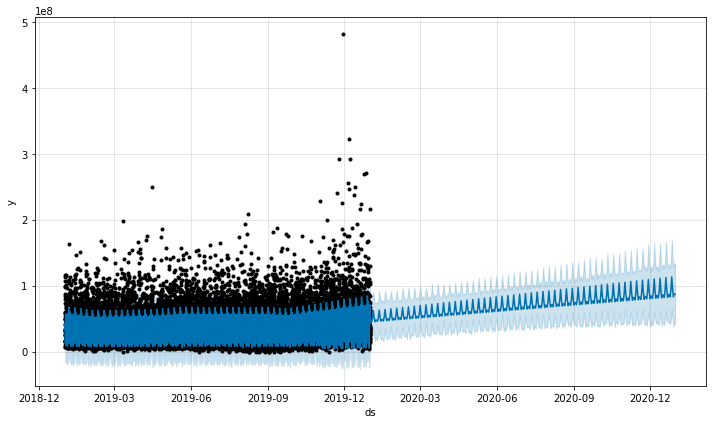

In [128]:
import matplotlib.pyplot as plt

fig1 = model.plot(forecast)

#### 연간으로 보면 9월이후 12월까지 값이 급증해 분산이 크게 증가함 -> outlier제거할 필요가 있어보임 

#### 주간으로 보면 일요일에 급증하고 월요일도 금요일저녁~토요일 만큼 비슷한 결과 (의외) 
#### 토 ~ 일요일에 급증해 일요일에 최고치를 찍고 일~화요일날에 급락

#### 일간으로 보면 황금시간대는 20시~24시 사이로 보임 

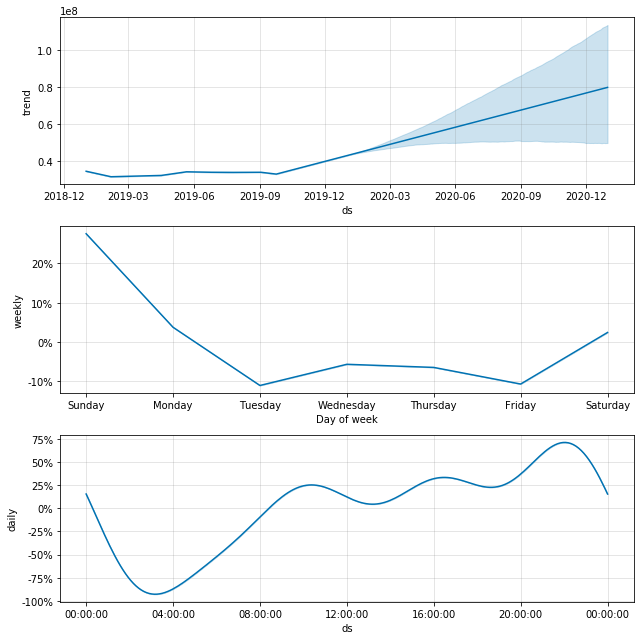

In [129]:
 fig2 = model.plot_components(forecast)

In [30]:
#90%의 범위에서 이동
model2 = Prophet(changepoint_range=0.9)

#### changepoint_prior_scale

- Change Point의 유연성을 조정하는 방법
    - 오버피팅이 심하면 너무 유연한 그래프가 나와서 모든 값에 근접하고, 언더피팅일 경우 유연성이 부족
        기본 값은 0.05
    - 이 값을 늘리면 그래프가 유연해지고(=언더피팅 해결), 이 값을 줄이면 유연성이 감소(=오버피팅 해결)

In [130]:
model2 = Prophet(changepoint_range=0.9,changepoint_prior_scale=0.05)
model2.fit(df_v)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


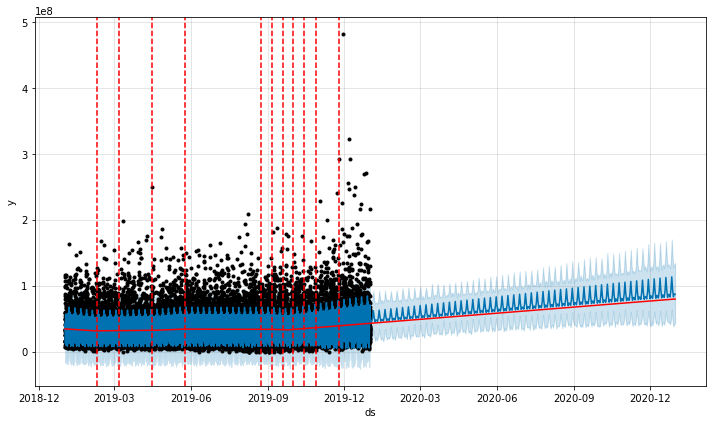

In [131]:
from fbprophet.plot import add_changepoints_to_plot
fig = model2.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model2, forecast)

#### 연간계절성을 보면 1월~12월이 매우높고 
#### 5월중순, 7월, 8월말, 10월중순에 높고 
#### 2~5월초, 9월 중순에 급락 

In [6]:
from fbprophet.plot import plot_yearly

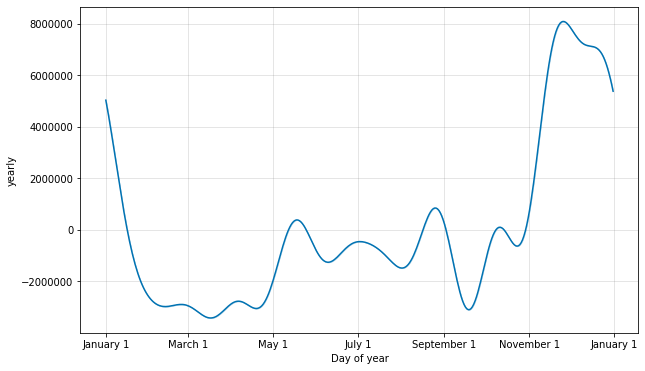

In [115]:
m = Prophet(yearly_seasonality=10).fit(df_v)
a = plot_yearly(m)

## 상품군별 Seasonality

In [133]:
cate_list= list(set(df['상품군']))

In [134]:
cate_list

['침구', '이미용', '가구', '건강기능', '생활용품', '의류', '주방', '농수축', '속옷', '가전', '잡화']

### 농수축자료 분석

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


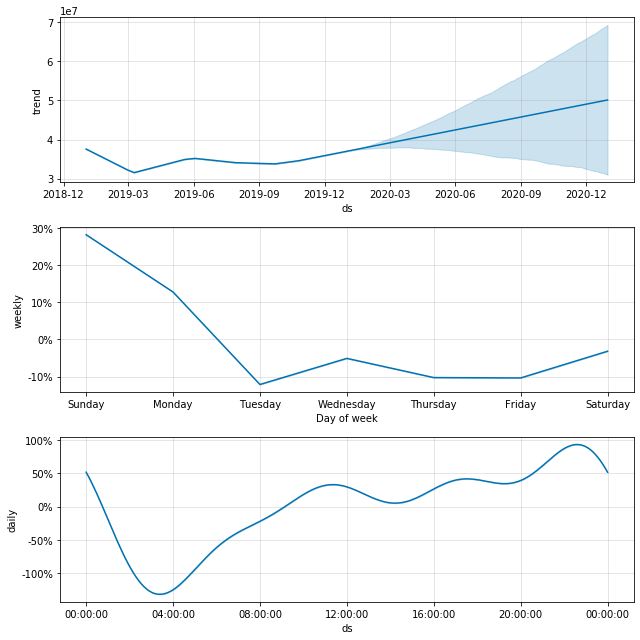

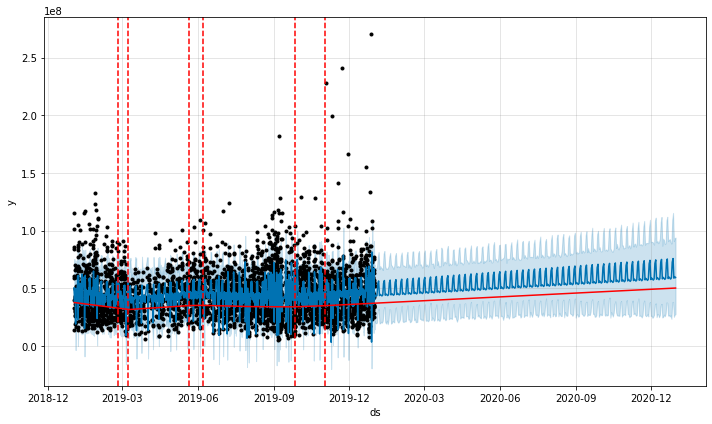

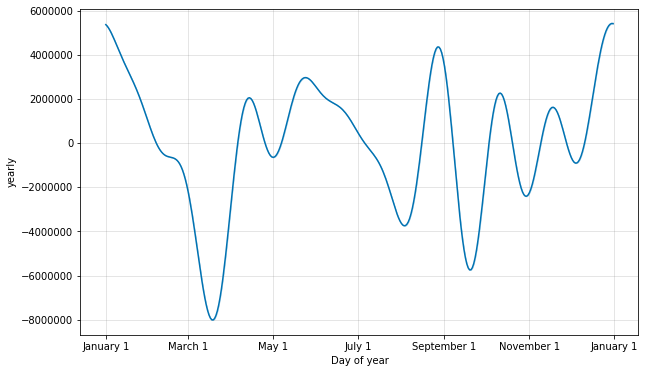

In [279]:
df_v = df[df['상품군']=='농수축'].pivot_table(index="ds", values="y", aggfunc=np.sum)
df_v['ds']= df_v.index
model = Prophet(seasonality_mode='multiplicative')
model.fit(df_v)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
fig2 = model.plot_components(forecast)
model2 = Prophet(changepoint_range=0.9,changepoint_prior_scale=0.05)
model2.fit(df_v)
fig = model2.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model2, forecast)
m = Prophet(yearly_seasonality=10).fit(df_v)
a = plot_yearly(m)

### 이미용자료 분석

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


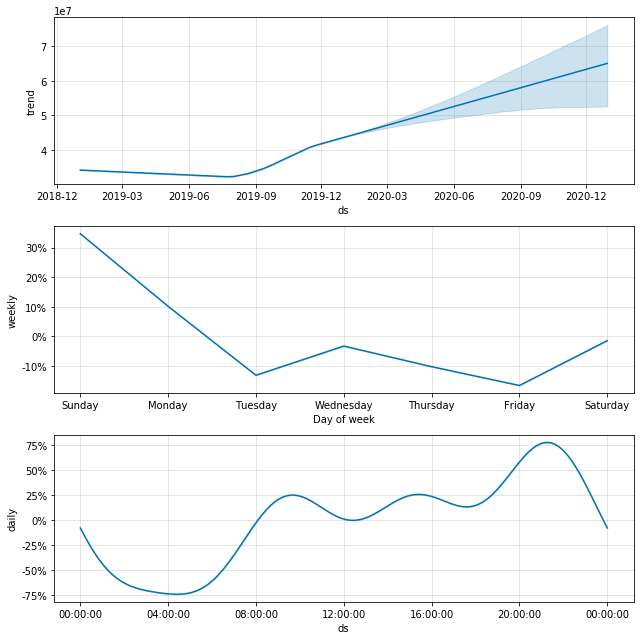

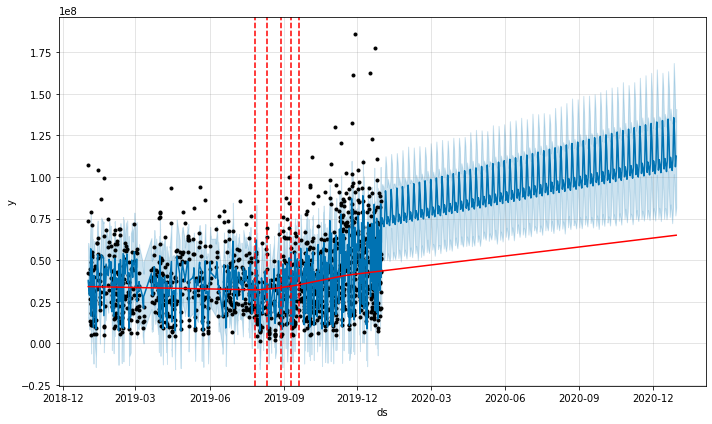

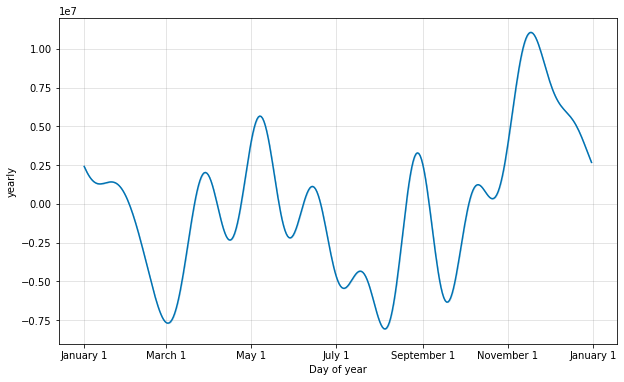

In [274]:
df_v = df[df['상품군']=='이미용'].pivot_table(index="ds", values="y", aggfunc=np.sum)
df_v['ds']= df_v.index
model = Prophet(seasonality_mode='multiplicative')
model.fit(df_v)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
fig2 = model.plot_components(forecast)
model2 = Prophet(changepoint_range=0.9,changepoint_prior_scale=0.05)
model2.fit(df_v)
fig = model2.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model2, forecast)
m = Prophet(yearly_seasonality=10).fit(df_v)
a = plot_yearly(m)

### 가전자료 분석 

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


NameError: name 'add_changepoints_to_plot' is not defined

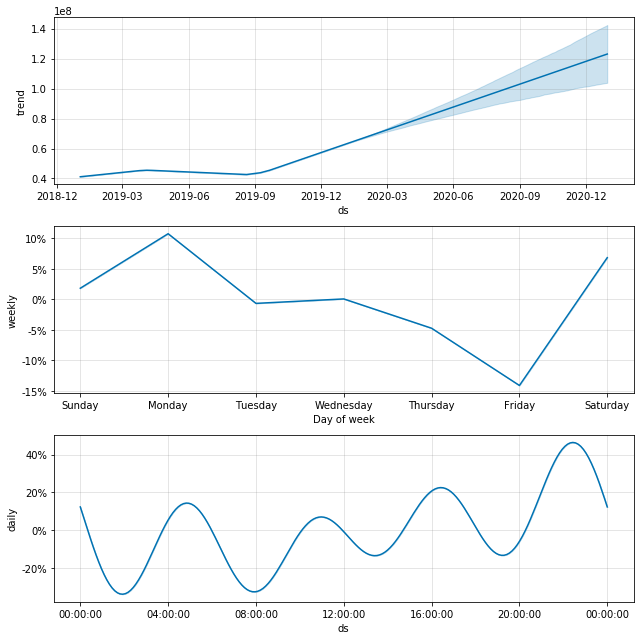

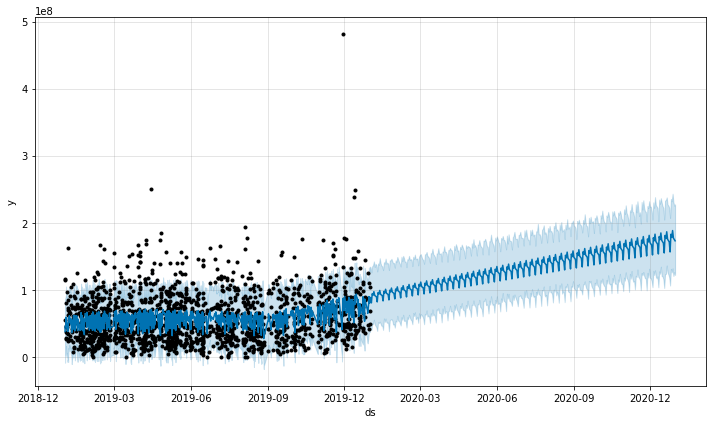

In [5]:
df_v = df[df['상품군']=='가전'].pivot_table(index="ds", values="y", aggfunc=np.sum)
df_v['ds']= df_v.index
model = Prophet(seasonality_mode='multiplicative')
model.fit(df_v)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
fig2 = model.plot_components(forecast)
model2 = Prophet(changepoint_range=0.9,changepoint_prior_scale=0.05)
model2.fit(df_v)
fig = model2.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model2, forecast)
m = Prophet(yearly_seasonality=10).fit(df_v)
a = plot_yearly(m)

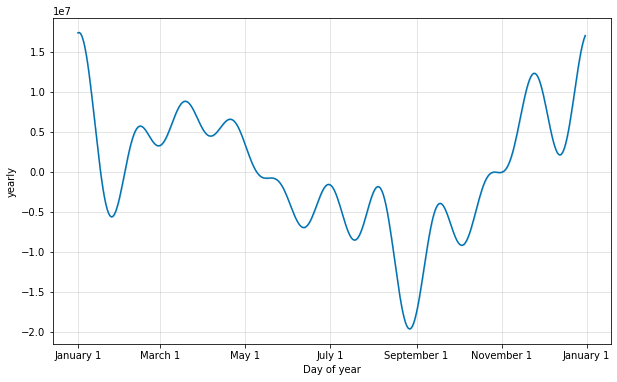

In [8]:
df_e = df[df['상품군']=='가전'].pivot_table(index="ds", values="y", aggfunc=np.sum)
df_e['ds']= df_e.index
m1 = Prophet(yearly_seasonality=10).fit(df_e)
a = plot_yearly(m1)

In [ ]:
df_u = df[df['상품군']=='속옷'].pivot_table(index="ds", values="y", aggfunc=np.sum)
df_u['ds']= df_u.index

m1 = Prophet(yearly_seasonality=10).fit(df_e)
m2 = Prophet(yearly_seasonality=10).fit(df_u)

In [287]:
m1.summary()

AttributeError: 'Prophet' object has no attribute 'summary'

### 침구자료 분석

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


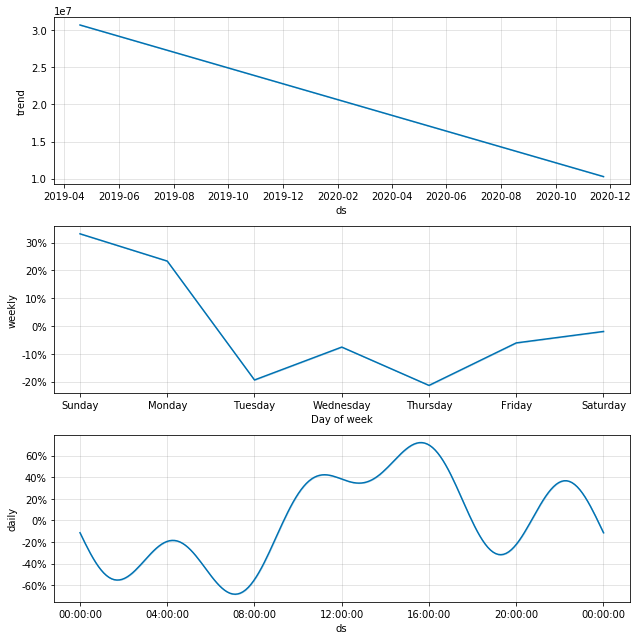

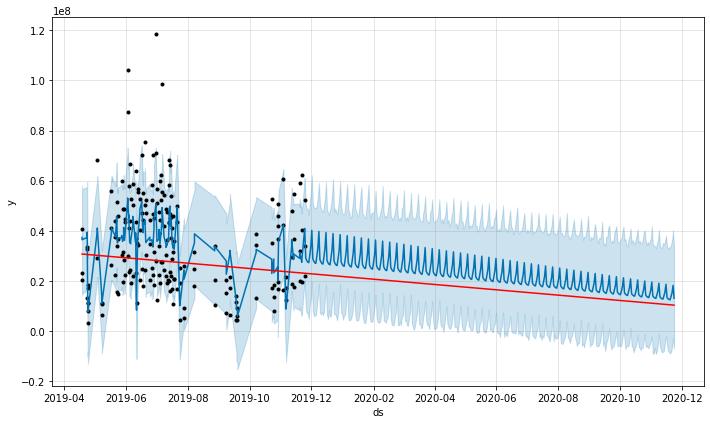

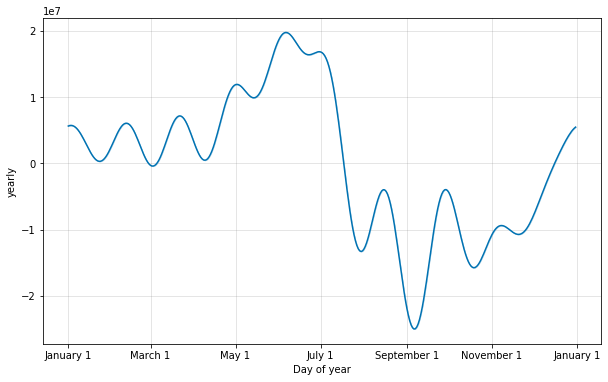

In [185]:
df_v = df[df['상품군']=='침구'].pivot_table(index="ds", values="y", aggfunc=np.sum)
df_v['ds']= df_v.index
model = Prophet(seasonality_mode='multiplicative')
model.fit(df_v)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
fig2 = model.plot_components(forecast)
model2 = Prophet(changepoint_range=0.9,changepoint_prior_scale=0.05)
model2.fit(df_v)
fig = model2.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model2, forecast)
m = Prophet(yearly_seasonality=10).fit(df_v)
a = plot_yearly(m)

### 속옷자료 분석

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


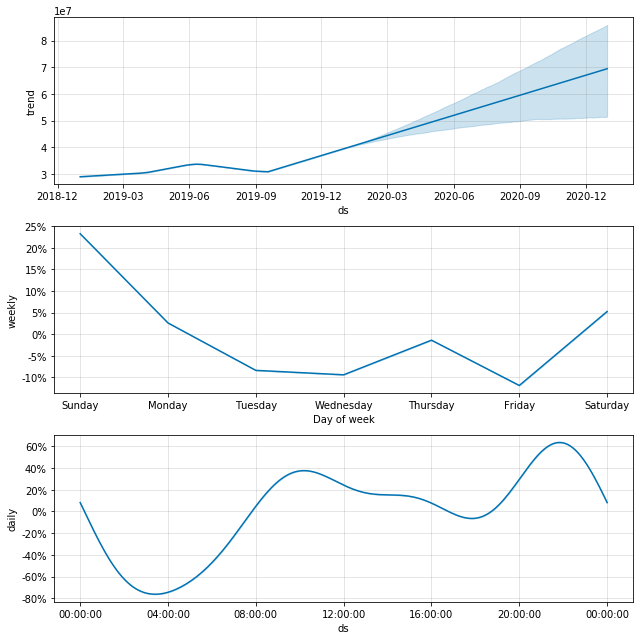

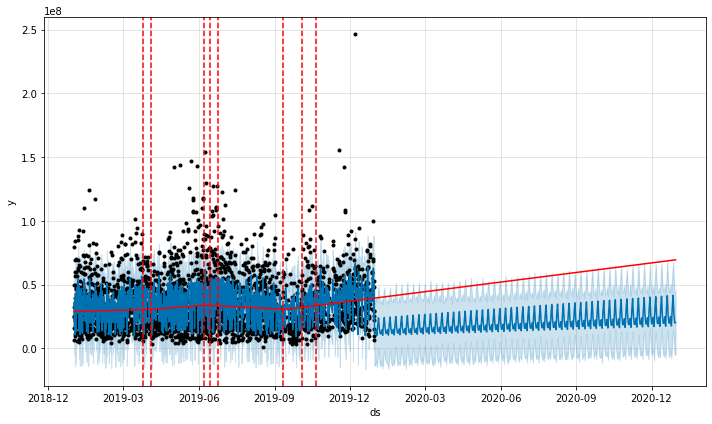

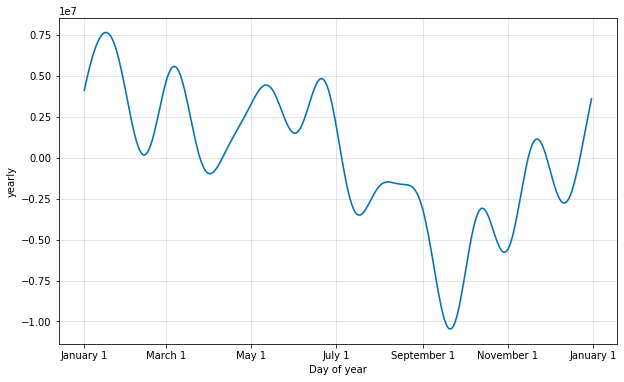

In [186]:
df_v = df[df['상품군']=='속옷'].pivot_table(index="ds", values="y", aggfunc=np.sum)
df_v['ds']= df_v.index
model = Prophet(seasonality_mode='multiplicative')
model.fit(df_v)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
fig2 = model.plot_components(forecast)
model2 = Prophet(changepoint_range=0.9,changepoint_prior_scale=0.05)
model2.fit(df_v)
fig = model2.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model2, forecast)
m = Prophet(yearly_seasonality=10).fit(df_v)
a = plot_yearly(m)

### 건강기능자료 분석

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


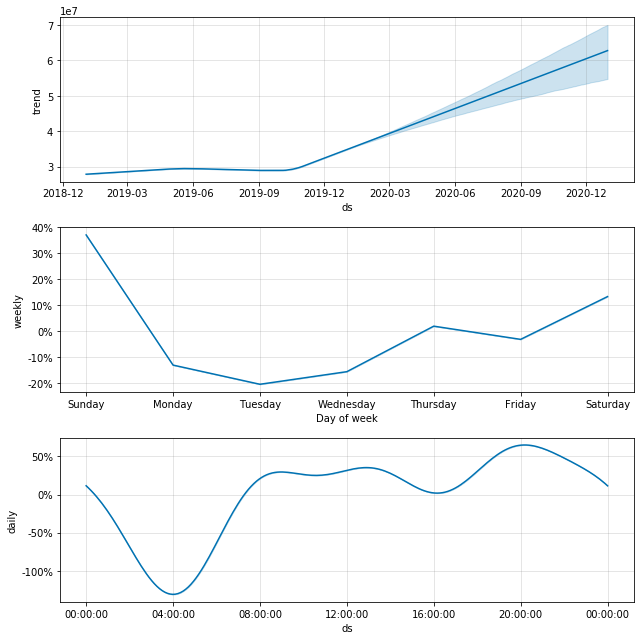

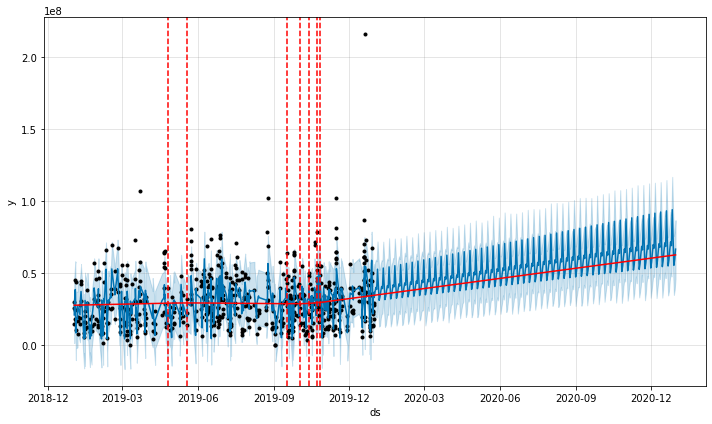

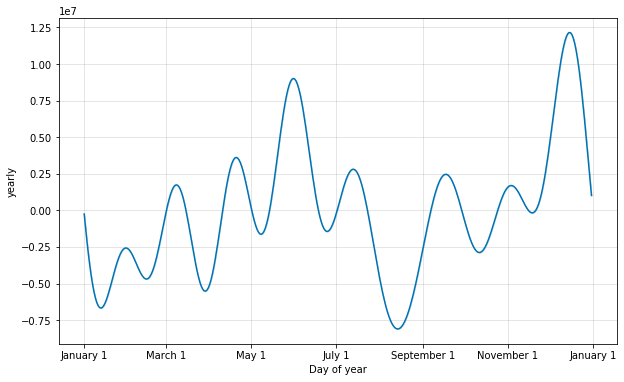

In [187]:
df_v = df[df['상품군']=='건강기능'].pivot_table(index="ds", values="y", aggfunc=np.sum)
df_v['ds']= df_v.index
model = Prophet(seasonality_mode='multiplicative')
model.fit(df_v)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
fig2 = model.plot_components(forecast)
model2 = Prophet(changepoint_range=0.9,changepoint_prior_scale=0.05)
model2.fit(df_v)
fig = model2.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model2, forecast)
m = Prophet(yearly_seasonality=10).fit(df_v)
a = plot_yearly(m)

### 의류자료 분석

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


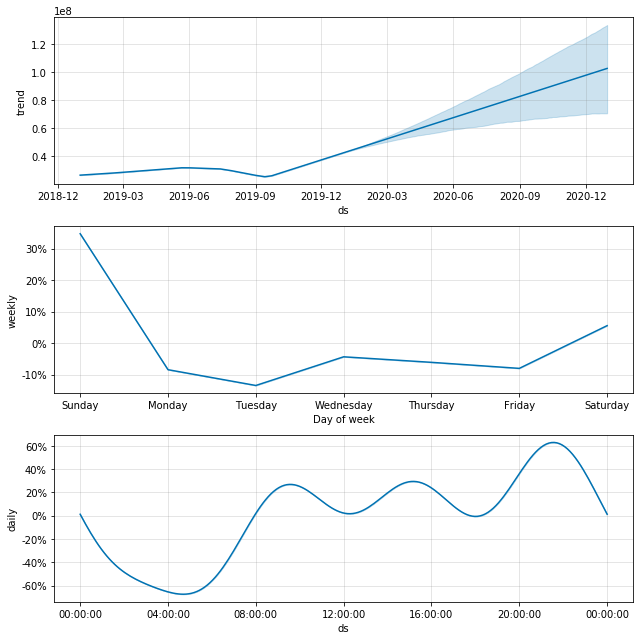

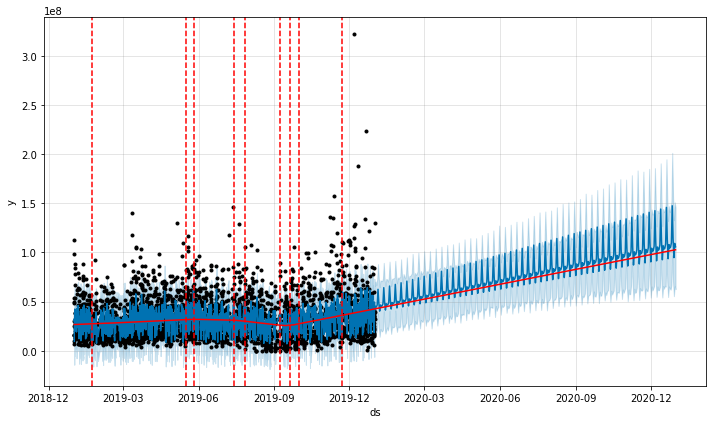

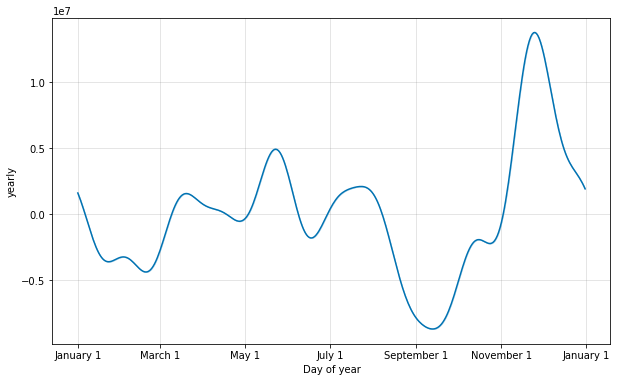

In [188]:
df_v = df[df['상품군']=='의류'].pivot_table(index="ds", values="y", aggfunc=np.sum)
df_v['ds']= df_v.index
model = Prophet(seasonality_mode='multiplicative')
model.fit(df_v)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
fig2 = model.plot_components(forecast)
model2 = Prophet(changepoint_range=0.9,changepoint_prior_scale=0.05)
model2.fit(df_v)
fig = model2.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model2, forecast)
m = Prophet(yearly_seasonality=10).fit(df_v)
a = plot_yearly(m)

### 생활용품자료 분석

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


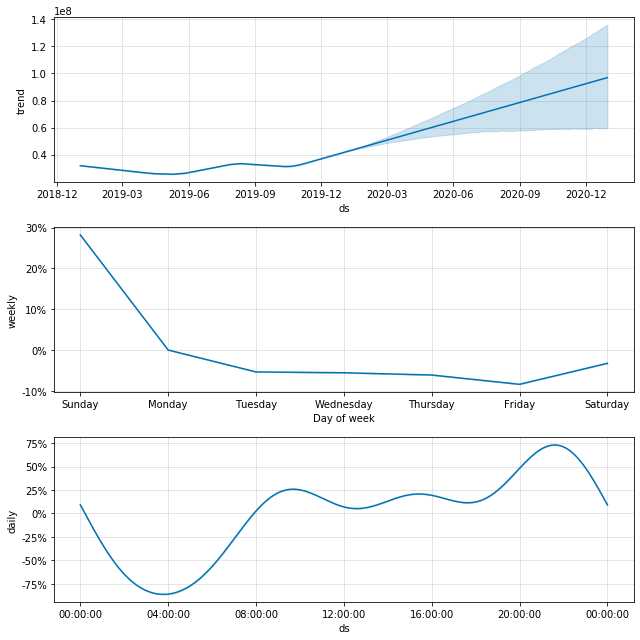

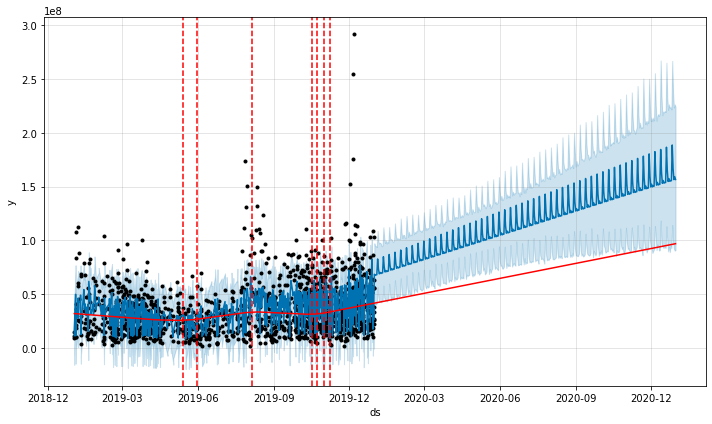

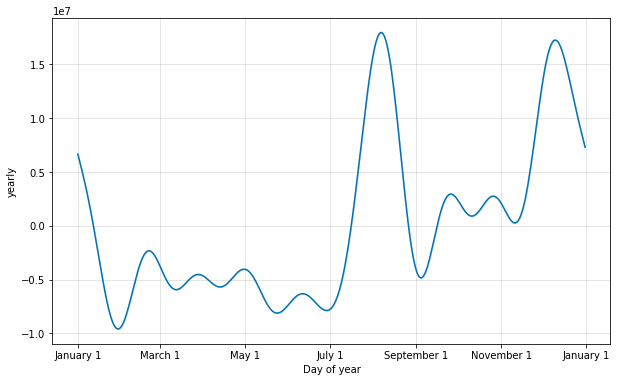

In [189]:
df_v = df[df['상품군']=='생활용품'].pivot_table(index="ds", values="y", aggfunc=np.sum)
df_v['ds']= df_v.index
model = Prophet(seasonality_mode='multiplicative')
model.fit(df_v)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
fig2 = model.plot_components(forecast)
model2 = Prophet(changepoint_range=0.9,changepoint_prior_scale=0.05)
model2.fit(df_v)
fig = model2.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model2, forecast)
m = Prophet(yearly_seasonality=10).fit(df_v)
a = plot_yearly(m)

### 주방자료 분석|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


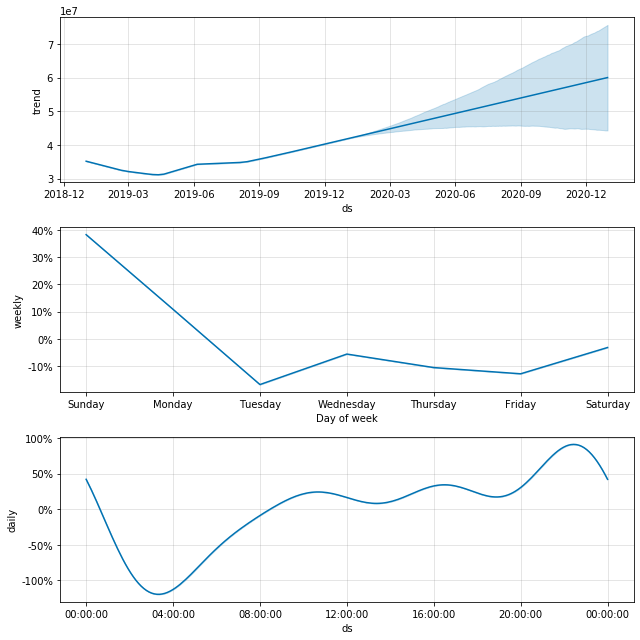

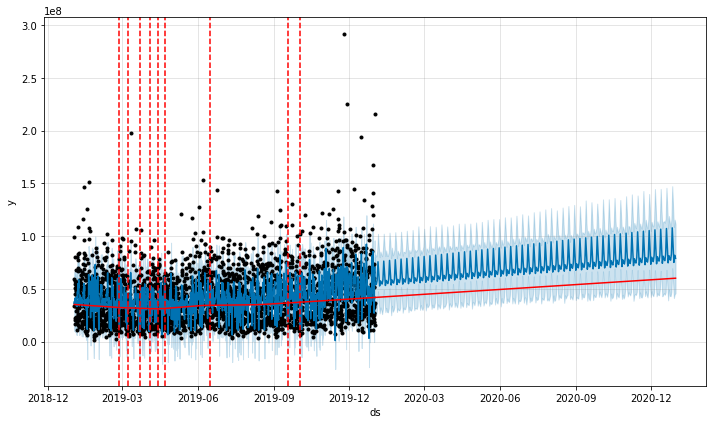

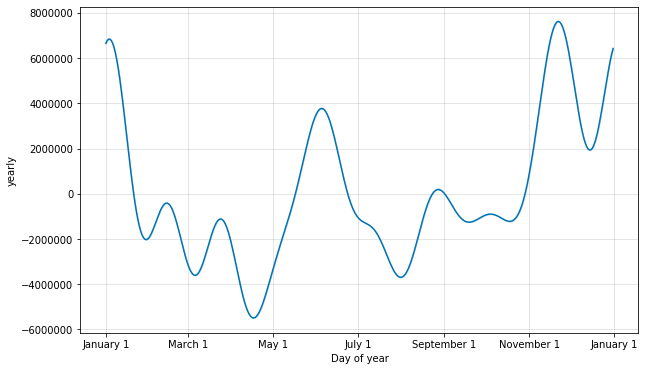

In [190]:
df_v = df[df['상품군']=='주방'].pivot_table(index="ds", values="y", aggfunc=np.sum)
df_v['ds']= df_v.index
model = Prophet(seasonality_mode='multiplicative')
model.fit(df_v)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
fig2 = model.plot_components(forecast)
model2 = Prophet(changepoint_range=0.9,changepoint_prior_scale=0.05)
model2.fit(df_v)
fig = model2.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model2, forecast)
m = Prophet(yearly_seasonality=10).fit(df_v)
a = plot_yearly(m)

### 잡화자료

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


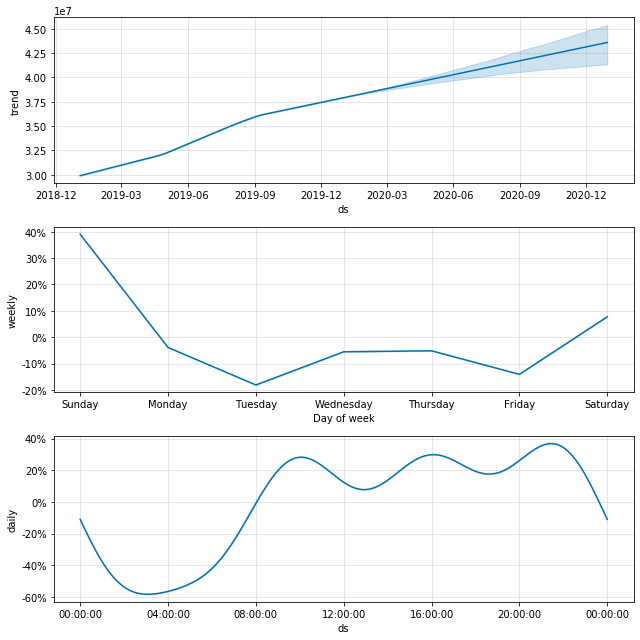

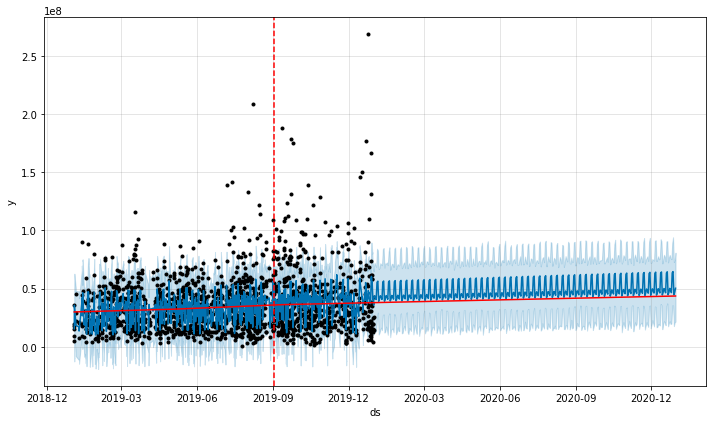

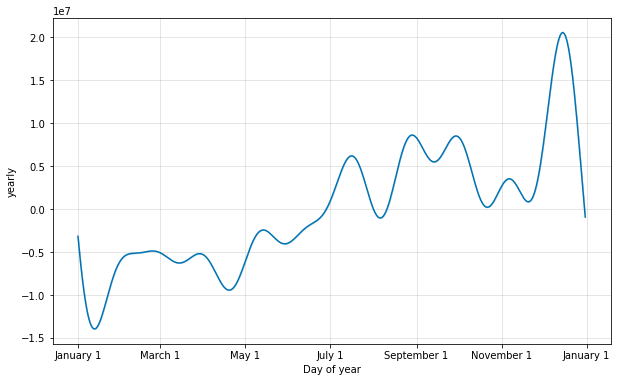

In [191]:
df_v = df[df['상품군']=='잡화'].pivot_table(index="ds", values="y", aggfunc=np.sum)
df_v['ds']= df_v.index
model = Prophet(seasonality_mode='multiplicative')
model.fit(df_v)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
fig2 = model.plot_components(forecast)
model2 = Prophet(changepoint_range=0.9,changepoint_prior_scale=0.05)
model2.fit(df_v)
fig = model2.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model2, forecast)
m = Prophet(yearly_seasonality=10).fit(df_v)
a = plot_yearly(m)

### 가구자료

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


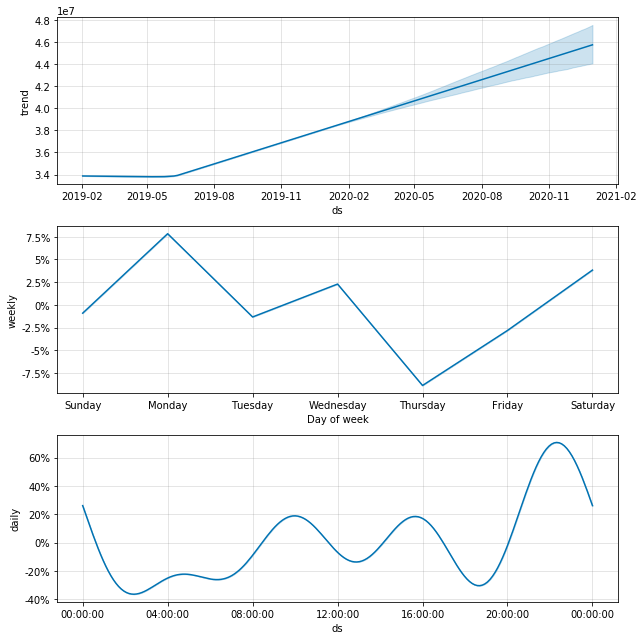

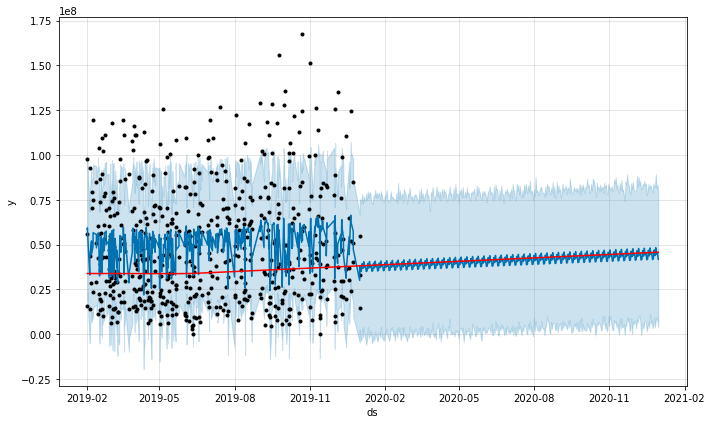

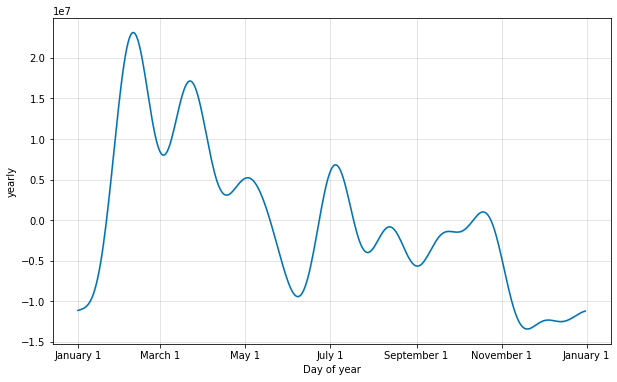

In [192]:
df_v = df[df['상품군']=='가구'].pivot_table(index="ds", values="y", aggfunc=np.sum)
df_v['ds']= df_v.index
model = Prophet(seasonality_mode='multiplicative')
model.fit(df_v)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
fig2 = model.plot_components(forecast)
model2 = Prophet(changepoint_range=0.9,changepoint_prior_scale=0.05)
model2.fit(df_v)
fig = model2.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model2, forecast)
m = Prophet(yearly_seasonality=10).fit(df_v)
a = plot_yearly(m)

In [249]:
df[df['취급액']==df[df['상품군']=='가전']['취급액'].max()]

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,ds,y,broad,value
35045,2019-11-29 23:00:00,20.0,100148,200412,LG 울트라HD TV 65UM7900BNA,가전,1700000,231789000.0,2019-11-29 23:00:00,231789000.0,2019-11-29,231789000.0


In [220]:
#outlier?? 136대 팔림 
df[df['취급액']==231789000.0]

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,ds,y
35045,2019-11-29 23:00:00,20.0,100148,200412,LG 울트라HD TV 65UM7900BNA,가전,1700000,231789000.0,2019-11-29 23:00:00,231789000.0


In [227]:
df[df['상품코드']==200412].pivot_table(index="ds", values="y", aggfunc=np.sum)/1700000

,y
ds,
2019-11-29 22:20:00,22.174118
2019-11-29 22:40:00,4.884706
2019-11-29 23:00:00,136.346471
2019-11-30 21:20:00,4.958824
2019-11-30 21:40:00,34.830000
2019-11-30 22:00:00,49.780588
2019-12-05 21:20:00,12.559412
2019-12-05 21:40:00,27.607647
2019-12-05 22:00:00,25.149412


In [229]:
temp = df

broad = [str(x)[:10] for x in df['방송일시'].values ]
temp['broad'] = broad
temp['value'] = df['취급액']
temp['broad'] = np.where(temp['broad'] == '2020-01-01', '2019-12-31', temp['broad'])
temp["broad"] = pd.to_datetime(temp["broad"], format='%Y-%m-%d', errors='raise')

In [232]:
temp[temp['상품코드']==200412].pivot_table(index="ds", values="y", aggfunc=np.sum)/1700000

,y
ds,
2019-11-29 22:20:00,22.174118
2019-11-29 22:40:00,4.884706
2019-11-29 23:00:00,136.346471
2019-11-30 21:20:00,4.958824
2019-11-30 21:40:00,34.830000
2019-11-30 22:00:00,49.780588
2019-12-05 21:20:00,12.559412
2019-12-05 21:40:00,27.607647
2019-12-05 22:00:00,25.149412


In [233]:
temp[temp['상품코드']==200412].pivot_table(index="broad", values="value", aggfunc=np.sum)/1700000

,value
broad,
2019-11-29,163.405294
2019-11-30,89.569412
2019-12-05,65.316471
2019-12-07,63.098824
2019-12-09,95.278235
2019-12-12,80.418824
2019-12-13,92.887059
2019-12-17,110.761765
2019-12-19,70.728235


In [234]:
temp[temp['상품코드']==200412].pivot_table(index="broad", values="value", aggfunc=np.sum)

,value
broad,
2019-11-29,277789000.0
2019-11-30,152268000.0
2019-12-05,111038000.0
2019-12-07,107268000.0
2019-12-09,161973000.0
2019-12-12,136712000.0
2019-12-13,157908000.0
2019-12-17,188295000.0
2019-12-19,120238000.0


In [238]:
df[df['취급액']==df['취급액'].max()]

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,ds,y,broad,value
35784,2019-12-07 01:40:00,17.166667,100418,201322,코몽트 덤블 플리스 자켓 2종,의류,39900,322009000.0,2019-12-07 01:40:00,322009000.0,2019-12-07,322009000.0


In [241]:
df[df['상품코드']==201322].pivot_table(index="ds", values="y", aggfunc=np.sum)/39900

,y
ds,
2019-12-07 01:20:00,594.536341
2019-12-07 01:40:00,8070.401003
2019-12-07 08:20:00,1411.478697
2019-12-07 08:40:00,2629.323308
2019-12-07 09:00:00,3231.954887
2019-12-10 23:20:00,780.350877
2019-12-10 23:40:00,1422.857143
2019-12-11 00:00:00,4697.218045
2019-12-11 12:20:00,538.822055


In [243]:
temp[temp['상품코드']==201322].pivot_table(index="broad", values="value", aggfunc=np.sum)/39900

,value
broad,
2019-12-07,15937.694236
2019-12-10,2203.208020
2019-12-11,7815.162907
2019-12-15,5270.701754
2019-12-17,4168.245614
2019-12-21,6425.639098
2019-12-22,5774.360902
2019-12-23,1652.506266
2019-12-24,2840.275689


In [251]:
temp[temp['상품코드']==201322].pivot_table(index="broad", values="value", aggfunc=np.sum)

,value
broad,
2019-12-07,635914000.0
2019-12-10,87908000.0
2019-12-11,311825000.0
2019-12-15,210301000.0
2019-12-17,166313000.0
2019-12-21,256383000.0
2019-12-22,230397000.0
2019-12-23,65935000.0
2019-12-24,113327000.0


In [255]:
temp.pivot_table(index="broad", values="value", aggfunc=np.sum).max()

value    3.652685e+09
dtype: float64

In [256]:
max_temp= temp.pivot_table(index="broad", values="value", aggfunc=np.sum)

In [258]:
max_temp[max_temp['value']==3.652685e+09]

,value
broad,
2019-12-07,3.652685e+09


In [261]:
df[df['broad']=='2019-12-07']

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,ds,y,broad,value
35783,2019-12-07 01:20:00,20.000000,100418,201322,코몽트 덤블 플리스 자켓 2종,의류,39900,23722000.0,2019-12-07 01:20:00,23722000.0,2019-12-07,23722000.0
35784,2019-12-07 01:40:00,17.166667,100418,201322,코몽트 덤블 플리스 자켓 2종,의류,39900,322009000.0,2019-12-07 01:40:00,322009000.0,2019-12-07,322009000.0
35785,2019-12-07 06:20:00,20.000000,100262,200876,더블모 어성초 샴푸,이미용,59800,23332000.0,2019-12-07 06:20:00,23332000.0,2019-12-07,23332000.0
35786,2019-12-07 06:40:00,20.000000,100262,200876,더블모 어성초 샴푸,이미용,59800,38932000.0,2019-12-07 06:40:00,38932000.0,2019-12-07,38932000.0
35787,2019-12-07 07:00:00,20.000000,100262,200876,더블모 어성초 샴푸,이미용,59800,49227000.0,2019-12-07 07:00:00,49227000.0,2019-12-07,49227000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
35874,2019-12-07 22:20:00,20.000000,100148,200413,LG 울트라HD TV 75UM7900BNA,가전,2840000,14013000.0,2019-12-07 22:20:00,14013000.0,2019-12-07,14013000.0
35875,2019-12-07 22:40:00,20.000000,100099,200278,라쉬반 프레쉬 에어 에디션 드로즈 패키지(+캐리어),속옷,119000,18705000.0,2019-12-07 22:40:00,18705000.0,2019-12-07,18705000.0
35876,2019-12-07 22:40:00,20.000000,100099,200277,라쉬반 레알마드리드 에디션 드로즈 패키지(+캐리어),속옷,119000,11189000.0,2019-12-07 22:40:00,11189000.0,2019-12-07,11189000.0
35877,2019-12-07 23:00:00,20.000000,100099,200278,라쉬반 프레쉬 에어 에디션 드로즈 패키지(+캐리어),속옷,119000,60799000.0,2019-12-07 23:00:00,60799000.0,2019-12-07,60799000.0


내가 생각하는 중요피쳐 :
    1. 이게 황금시간대냐?
    2. 이게 토일월이냐 화수목이냐 
    3. 상품군별 seasonality
    )li

In [18]:
list_i = []
for i in range(len(forecast)):
    if forecast['ds'][i].month==6 :
        list_i.append(i)
        

In [20]:
index = range(list_i[0],list_i[-1])

In [21]:
index

range(893, 1868)

In [23]:
forecast['ds'][10].weekday()

3

In [24]:
forecast['ds'][10]

Timestamp('2019-01-03 21:20:00')

In [25]:
list_a = [None]

In [26]:
a in list_a

False

In [28]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2019-01-01 20:00:00,4.116974e+07,-8.609868e+06,8.079496e+07,4.116974e+07,4.116974e+07,-0.057606,-0.057606,-0.057606,-0.077735,-0.077735,-0.077735,-0.020130,-0.020130,-0.020130,0.0,0.0,0.0,3.796940e+07
1,2019-01-01 20:20:00,4.117045e+07,-3.110289e+06,8.214752e+07,4.117045e+07,4.117045e+07,0.015669,0.015669,0.015669,-0.002775,-0.002775,-0.002775,-0.018444,-0.018444,-0.018444,0.0,0.0,0.0,4.105622e+07
2,2019-01-01 20:40:00,4.117115e+07,1.008054e+06,8.619904e+07,4.117115e+07,4.117115e+07,0.105448,0.105448,0.105448,0.088710,0.088710,0.088710,-0.016738,-0.016738,-0.016738,0.0,0.0,0.0,4.482343e+07
3,2019-01-02 21:00:00,4.122247e+07,4.895767e+06,9.176425e+07,4.122247e+07,4.122247e+07,0.202579,0.202579,0.202579,0.182646,0.182646,0.182646,-0.019932,-0.019932,-0.019932,0.0,0.0,0.0,4.875160e+07
4,2019-01-02 21:20:00,4.122317e+07,5.674648e+06,9.627246e+07,4.122317e+07,4.122317e+07,0.296654,0.296654,0.296654,0.273849,0.273849,0.273849,-0.022805,-0.022805,-0.022805,0.0,0.0,0.0,5.251210e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2047,2020-12-26 22:00:00,1.224041e+08,1.259388e+08,2.320516e+08,1.035679e+08,1.414165e+08,0.434707,0.434707,0.434707,0.455363,0.455363,0.455363,0.020657,0.020657,0.020657,0.0,0.0,0.0,1.781424e+08
2048,2020-12-27 22:00:00,1.225702e+08,1.319397e+08,2.432873e+08,1.036461e+08,1.416541e+08,0.434707,0.434707,0.434707,0.536590,0.536590,0.536590,0.101884,0.101884,0.101884,0.0,0.0,0.0,1.883401e+08
2049,2020-12-28 22:00:00,1.227362e+08,1.205314e+08,2.306320e+08,1.037242e+08,1.418917e+08,0.434707,0.434707,0.434707,0.442989,0.442989,0.442989,0.008283,0.008283,0.008283,0.0,0.0,0.0,1.771071e+08
2050,2020-12-29 22:00:00,1.229023e+08,1.263602e+08,2.254577e+08,1.038003e+08,1.421598e+08,0.434707,0.434707,0.434707,0.424934,0.424934,0.424934,-0.009773,-0.009773,-0.009773,0.0,0.0,0.0,1.751277e+08
